In [1]:
# Jupyter Notebook: Updated Simulation of Parlay Smart Contract LP with Dynamic Odds and Partial Hedging

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
from functools import lru_cache
from joblib import Parallel, delayed

# Set display options
%matplotlib inline


Introduction

This is a simulation of our smart contract LP. It reads the odds of whitelisted prediction market and lets users place parlays from 2-10 legs. The payout is inline with the odds of all events occurring with a set margin. This simulation will show the feasibility and profitability of this system.

Rules:

    The balance of the contract may never be negative, wagers must be refused if it is not possible to payout the winner
    Bets cannot be 'cashed out' early and only close with a win or loss
    All prediction markets resolve as either YES / NO. Invalid markets and multiple options are not considered
    All events are settled at the same time
    1000 parlays are placed each betting cycle, after the cycle winners are paid out and new markets whitelisted and the cycle starts again

Contract Parameters:

    The contract starts with $10000 of liquidity
    The reserves required for taking a single bet must not exceed 10% of the available liquidity
    Hedging wagers will be placed to reduce the amount of reserves required
    Reserves may be shared between bets in which the winner cannot possibly win in both scenarios
    A flat margin will be taken on all payouts to ensure a profit. Starts at 5% but subject to change
    There are a set of 10 unique events to make parlays on, subject to change

Bettors:

    Bets are made in random sizes
    Bets are made with random number of legs 
    Prediction market odds are not static, but normally distributed around 50%, parlay odds are correlated to calculated odds and number of legs





1. Setting Up the Simulation
1.1 Initialize Contract Parameters

In [2]:
# Contract parameters
starting_liquidity = 10000.0  # Starting liquidity in dollars
liquidity = starting_liquidity  # Current liquidity
max_exposure_per_bet = 0.10  # 10% of available liquidity
flat_margin = 0.05  # 5% margin
num_events = 10  # Number of unique events
events = [f'Event_{i+1}' for i in range(num_events)]  # List of event names
betting_cycles = 10  # Number of betting cycles to simulate
odds_limit = 1000.0  # Maximum allowed odds (1000 to 1)
MAX_EVENTS_FOR_SHARED_RESERVES = 12  # Limit for computational feasibility

1.2 Define Bet

In [3]:
# Bettor parameters
num_bettors_per_cycle = 1000  # Number of bettors per betting cycle
min_bet_size = 1.0  # Minimum bet size
max_bet_size = 100.0  # Maximum bet size
min_legs = 2  # Minimum number of legs in a parlay
max_legs = 10  # Maximum number of legs in a parlay


1.3 Initialize Data Structures

In [4]:
# Data structures to store simulation results
liquidity_over_time = [liquidity]
profit_over_time = []
num_simulation_runs= 5

In [5]:
# Initialize the hedge book outside the simulation function
from collections import defaultdict

# Hedge book structure: {(event, outcome): {'bet_size': total_bet_size, 'odds': best_odds}}
hedge_book = defaultdict(lambda: {'bet_size': 0.0, 'odds': float('inf')})


2. Simulating Betting Cycles

We will simulate a specified number of betting cycles. In each cycle:

    Simulate Bettor Behavior: Bettors place bets with random sizes and random legs. Event odds are generated dynamically for each bettor.
    Enforce Contract Rules: Bets exceeding liquidity constraints are refused.
    Calculate Reserves and Hedging: Determine the reserves required and apply hedging strategies, accounting for partial offsets due to different odds.
    Settle Bets: Simulate the outcomes and settle bets.
    Update Liquidity: Adjust the contract's liquidity based on payouts and profits.

2.1 Function to Simulate a Single Bet with Dynamic Odds

In [6]:
def simulate_single_bet():
    """
    Simulate a single bettor placing a parlay bet with dynamic odds.
    Returns the bet dictionary or None if the bet is rejected.
    """
    bet_size = np.random.uniform(min_bet_size, max_bet_size)
    num_legs = np.random.randint(min_legs, max_legs + 1)
    selected_events = np.random.choice(events, size=num_legs, replace=False)
    selected_outcomes = np.random.choice([0, 1], size=num_legs)  # 0: NO, 1: YES

    # Generate odds for the selected events at the time of bet placement
    selected_odds = []
    for event in selected_events:
        probability = np.clip(np.random.normal(0.5, 0.15), 0.1, 0.9)  # Probabilities between 0.1 and 0.9
        decimal_odds = 1 / probability  # Convert probability to decimal odds
        selected_odds.append(decimal_odds)

    # Calculate total odds for the parlay
    parlay_odds = np.prod(selected_odds)

    # Apply the margin
    parlay_odds_with_margin = parlay_odds / (1 + flat_margin)

    # Check if parlay odds exceed the odds limit
    if parlay_odds_with_margin > odds_limit:
        return None  # Bet is rejected due to high odds

    bet = {
        'bet_size': bet_size,
        'num_legs': num_legs,
        'selected_events': selected_events,
        'selected_outcomes': selected_outcomes,
        'selected_odds': selected_odds,
        'parlay_odds': parlay_odds_with_margin,
        'potential_payout': bet_size * parlay_odds_with_margin
    }
    return bet


Explanation:

    Dynamic Odds: For each bettor, we generate odds for their selected events at the time of bet placement. This simulates changing odds in the prediction markets.
    Event Odds Generation: The odds are generated based on probabilities normally distributed around 50%, ensuring they fall between 10% and 90%.

2.2 Function to Determine if a Bet Can Be Accepted Considering Shared Reserves

To consider shared reserves due to mutually exclusive bets, we need to calculate the maximum possible payout across all possible outcomes with the existing bets and the new bet. If adding the new bet doesn't increase the maximum possible payout beyond the liquidity, we can accept it.

Due to computational limitations, we will:

    Generate all possible outcome combinations of the events involved in the accepted bets and the new bet.
    Calculate the total potential payout for each outcome.
    Determine the maximum total payout.
    Compare it to the liquidity.

Note: Since the number of possible outcomes increases exponentially with the number of events, we need to limit the number of events considered.

To make it computationally feasible, we will:

    Limit the number of events considered to a manageable size, e.g., events involved in the current bets (usually less than or equal to 20).
    Use an efficient data structure to store and calculate payouts.

In [7]:
# Precompute all possible outcomes for a given number of events
from functools import lru_cache

@lru_cache(maxsize=None)
def get_all_possible_outcomes(num_events):
    return list(itertools.product([0, 1], repeat=num_events))


In [8]:
def can_accept_bet_with_shared_reserves(accepted_bets, new_bet, current_liquidity):
    # Combine events from accepted bets and the new bet
    events_in_bets = set()
    for bet in accepted_bets + [new_bet]:
        events_in_bets.update(bet['selected_events'])
    events_in_bets = list(events_in_bets)
    num_combined_events = len(events_in_bets)

    # If too many events, cannot compute all combinations
    if num_combined_events > 15:
        return False

    # Use cached outcomes
    all_possible_outcomes = get_all_possible_outcomes(num_combined_events)
    total_payouts = []

    for outcome in all_possible_outcomes:
        outcome_dict = dict(zip(events_in_bets, outcome))
        total_payout = 0.0

        # Check payouts for existing bets
        for bet in accepted_bets + [new_bet]:
            bet_wins = True
            for event, outcome_event in zip(bet['selected_events'], bet['selected_outcomes']):
                if outcome_dict.get(event, None) != outcome_event:
                    bet_wins = False
                    break
            if bet_wins:
                total_payout += bet['potential_payout']
        total_payouts.append(total_payout)

    max_total_payout = max(total_payouts)

    # If the maximum total payout exceeds current liquidity, cannot accept the bet
    if max_total_payout > current_liquidity:
        return False
    else:
        return True


2.3 Function to Calculate Reserves and Hedging

We will calculate the net exposure for each event outcome and place hedging bets accordingly. The reserves required will be adjusted based on the hedging positions.

Explanation:

    Net Exposure Calculation: We calculate the net exposure for each event by finding the difference in potential payouts between the two outcomes.
    Hedging Bets: The contract places hedging bets on the prediction market to offset the net exposure.
    Hedging Cost: The cost of hedging bets is accounted for, and we ensure it does not exceed liquidity.
    Reserves Required: After hedging, the net exposure (potential payouts to bettors) is reduced, and the reserves required are updated accordingly.

2.4 Functions to Simulate Event Outcomes and Settle Bets



In [9]:
def simulate_event_outcomes(events):
    """
    Simulate the outcomes of all events (0: NO, 1: YES).
    """
    outcomes = {}
    for event in events:
        outcomes[event] = np.random.choice([0, 1])
    return outcomes


In [10]:
def create_hedge_bets(bet, hedge_book):
    """
    Create hedge bets for the given bettor's bet.
    The hedge bets are on the same outcomes of each leg at the market odds.
    The hedge bet size is the same as the bettor's wager per event.
    Hedges are shared between bets; we only place additional hedges if the current odds are lower.
    """
    hedge_bets = []
    bettor_wager = bet['bet_size']  # Bettor's wager per event
    
    for event, outcome, odds in zip(bet['selected_events'], bet['selected_outcomes'], bet['selected_odds']):
        key = (event, outcome)
        market_odds = odds  # Current market odds
        
        # Check if we already have a hedge on this event and outcome
        existing_hedge = hedge_book.get(key)
        if existing_hedge:
            # Compare current odds with the best odds we have hedged at
            if market_odds < existing_hedge['odds']:
                # Place an additional hedge at the better odds
                hedge_bet_size = bettor_wager
                hedge_bet = {
                    'event': event,
                    'outcome': outcome,
                    'odds': market_odds,
                    'bet_size': hedge_bet_size,
                    'potential_payout': hedge_bet_size * market_odds
                }
                hedge_bets.append(hedge_bet)
                
                # Update the hedge book with the new best odds and cumulative bet size
                hedge_book[key]['bet_size'] += hedge_bet_size
                hedge_book[key]['odds'] = market_odds
            else:
                # Skip hedging since we have already hedged at better or equal odds
                continue
        else:
            # No existing hedge; place a new hedge
            hedge_bet_size = bettor_wager
            hedge_bet = {
                'event': event,
                'outcome': outcome,
                'odds': market_odds,
                'bet_size': hedge_bet_size,
                'potential_payout': hedge_bet_size * market_odds
            }
            hedge_bets.append(hedge_bet)
            
            # Add the new hedge to the hedge book
            hedge_book[key] = {'bet_size': hedge_bet_size, 'odds': market_odds}
    
    return hedge_bets


Explanation:

    Settling Bets: Calculate the total payout to bettors based on the outcomes.
    Settling Hedging Bets: Calculate the returns from hedging bets based on event outcomes.

3. Running the Simulation

In [11]:
# for cycle in range(betting_cycles):
#     print(f"--- Betting Cycle {cycle + 1} ---")
#     accepted_bets = []
#     total_wagers = 0.0
#     total_payout_to_bettors = 0.0

#     for _ in range(num_bettors_per_cycle):
#         # Simulate a single bet
#         bet = simulate_single_bet()
#         if bet is None:
#             continue  # Bet was rejected due to odds limit

#         # Check if required reserve exceeds max exposure per bet
#         required_reserve = bet['potential_payout'] - bet['bet_size']
#         max_allowed_reserve = liquidity * max_exposure_per_bet
#         if required_reserve > max_allowed_reserve:
#             continue  # Bet is rejected due to liquidity constraints

#         # Check if bet can be accepted considering shared reserves
#         can_accept = can_accept_bet_with_shared_reserves(accepted_bets, bet, liquidity)
#         if not can_accept:
#             continue  # Bet is rejected due to insufficient liquidity after considering shared reserves

#         # Accept the bet
#         accepted_bets.append(bet)
#         total_wagers += bet['bet_size']

#     # If no bets were accepted, ensure we still update the arrays
#     if not accepted_bets:
#         print("No bets were accepted this cycle.")
#         profit_over_time.append(0.0)
#         liquidity_over_time.append(liquidity)
#         continue  # Move to the next cycle

#     # Simulate event outcomes
#     event_outcomes = simulate_event_outcomes(events)

#     # Settle bets and calculate total payout to bettors
#     for bet in accepted_bets:
#         bet_wins = True
#         for event, outcome in zip(bet['selected_events'], bet['selected_outcomes']):
#             if event_outcomes[event] != outcome:
#                 bet_wins = False
#                 break
#         if bet_wins:
#             total_payout_to_bettors += bet['potential_payout']

#     # Update liquidity
#     profit = total_wagers - total_payout_to_bettors
#     liquidity += profit

#     # Ensure liquidity does not go negative
#     if liquidity < 0:
#         liquidity = 0.0

#     liquidity_over_time.append(liquidity)
#     profit_over_time.append(profit)

#     print(f"Cycle {cycle + 1} Results:")
#     print(f"Total Bets Accepted: {len(accepted_bets)}")
#     print(f"Total Wagers Collected: ${total_wagers:.2f}")
#     print(f"Total Payout to Bettors: ${total_payout_to_bettors:.2f}")
#     print(f"Profit for the Cycle: ${profit:.2f}")
#     print(f"Updated Liquidity: ${liquidity:.2f}\n")


Explanation:

    Dynamic Odds and Partial Hedging: The simulation now accounts for dynamic odds and partial hedging when calculating reserves.
    Adjusting Accepted Bets: If total reserves required exceed available liquidity, the simulation removes bets with the highest potential payout until the reserves required are within liquidity constraints.
    Liquidity Updates: The liquidity is updated after each cycle based on the actual bets accepted and the outcomes.

In [12]:
def run_simulation(run_number):
    # Initialize variables for each run
    liquidity = starting_liquidity
    liquidity_over_time = [liquidity]
    profit_over_time = []
    total_hedging_costs = []
    total_hedging_returns = []
    total_hedging_net = []
    hedge_book = defaultdict(lambda: {'bet_size': 0.0, 'odds': float('inf')})  # Reset hedge book for each run

    for cycle in range(betting_cycles):
        accepted_bets = []
        hedge_bets = []
        total_wagers = 0.0
        total_payout_to_bettors = 0.0
        total_hedging_cost = 0.0
        total_hedging_return = 0.0

        for _ in range(num_bettors_per_cycle):
            # Simulate a single bet
            bet = simulate_single_bet()
            if bet is None:
                continue  # Bet was rejected due to odds limit

            # Check if required reserve exceeds max exposure per bet
            required_reserve = bet['potential_payout'] - bet['bet_size']
            max_allowed_reserve = liquidity * max_exposure_per_bet
            if required_reserve > max_allowed_reserve:
                continue  # Bet is rejected due to liquidity constraints

            # Check if bet can be accepted considering shared reserves
            can_accept = can_accept_bet_with_shared_reserves(accepted_bets, bet, liquidity)
            if not can_accept:
                continue  # Bet is rejected due to insufficient liquidity after considering shared reserves

            # Accept the bet
            accepted_bets.append(bet)
            total_wagers += bet['bet_size']

            # Create hedge bets on individual legs, sharing hedges
            hedge_bets_for_bet = create_hedge_bets(bet, hedge_book)
            hedge_bet_total_cost = sum(hb['bet_size'] for hb in hedge_bets_for_bet)

            # Check if we have enough liquidity to place the hedge bets
            if liquidity - hedge_bet_total_cost < 0:
                continue  # Cannot afford to hedge
            else:
                liquidity -= hedge_bet_total_cost
                total_hedging_cost += hedge_bet_total_cost
                hedge_bets.extend(hedge_bets_for_bet)

        # If no bets were accepted, ensure we still update the arrays
        if not accepted_bets:
            profit_over_time.append(0.0)
            liquidity_over_time.append(liquidity)
            total_hedging_costs.append(0.0)
            total_hedging_returns.append(0.0)
            total_hedging_net.append(0.0)
            continue  # Move to the next cycle

        # Simulate event outcomes
        event_outcomes = simulate_event_outcomes(events)

        # Settle bets and calculate total payout to bettors
        for bet in accepted_bets:
            bet_wins = True
            for event, outcome in zip(bet['selected_events'], bet['selected_outcomes']):
                if event_outcomes[event] != outcome:
                    bet_wins = False
                    break
            if bet_wins:
                total_payout_to_bettors += bet['potential_payout']

        # Settle hedge bets and calculate total hedging return
        for hedge_bet in hedge_bets:
            event = hedge_bet['event']
            outcome = hedge_bet['outcome']
            if event_outcomes[event] == outcome:
                # Hedge bet wins
                total_hedging_return += hedge_bet['bet_size'] * hedge_bet['odds']

        # Calculate net hedging result
        net_hedging = total_hedging_return - total_hedging_cost

        # Update liquidity
        profit = (total_wagers - total_payout_to_bettors) + net_hedging
        liquidity += profit

        # Ensure liquidity does not go negative
        if liquidity < 0:
            liquidity = 0.0

        # Record results
        liquidity_over_time.append(liquidity)
        profit_over_time.append(profit)
        total_hedging_costs.append(total_hedging_cost)
        total_hedging_returns.append(total_hedging_return)
        total_hedging_net.append(net_hedging)

    # Return the results for this run
    return {
        'run_number': run_number,
        'liquidity_over_time': liquidity_over_time,
        'profit_over_time': profit_over_time,
        'ending_liquidity': liquidity,
        'total_hedging_costs': total_hedging_costs,
        'total_hedging_returns': total_hedging_returns,
        'total_hedging_net': total_hedging_net
    }


In [13]:
num_simulation_runs = 5
all_runs_results = []

for run in range(num_simulation_runs):
    print(f"Starting Simulation Run {run + 1}")
    simulation_result = run_simulation(run + 1)
    all_runs_results.append(simulation_result)
    print(f"Ending Liquidity for Run {run + 1}: ${simulation_result['ending_liquidity']:.2f}\n")


Starting Simulation Run 1
Ending Liquidity for Run 1: $9102.14

Starting Simulation Run 2
Ending Liquidity for Run 2: $6520.69

Starting Simulation Run 3
Ending Liquidity for Run 3: $5392.76

Starting Simulation Run 4
Ending Liquidity for Run 4: $12481.67

Starting Simulation Run 5
Ending Liquidity for Run 5: $11968.97



4. Results and Analysis
4.1 Liquidity Over Time

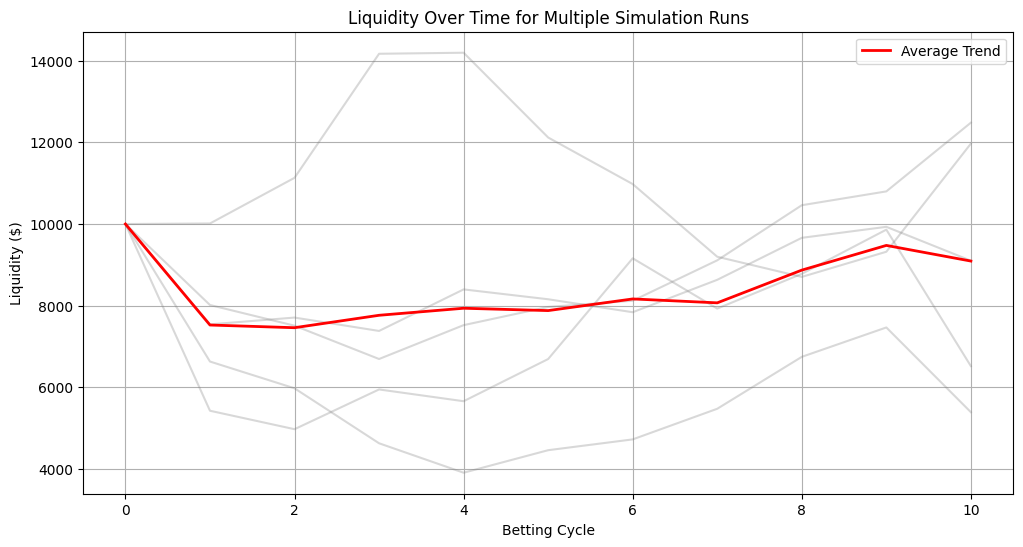

In [14]:
plt.figure(figsize=(12, 6))

# Plot individual run results
for result in all_runs_results:
    plt.plot(result['liquidity_over_time'], alpha=0.3, color='gray')

# Calculate and plot average trendline
avg_liquidity = np.mean([result['liquidity_over_time'] for result in all_runs_results], axis=0)
plt.plot(avg_liquidity, color='red', linewidth=2, label='Average Trend')

plt.title('Liquidity Over Time for Multiple Simulation Runs')
plt.xlabel('Betting Cycle')
plt.ylabel('Liquidity ($)')
plt.grid(True)
plt.legend()
plt.show()


4.2 Profit per Betting Cycle

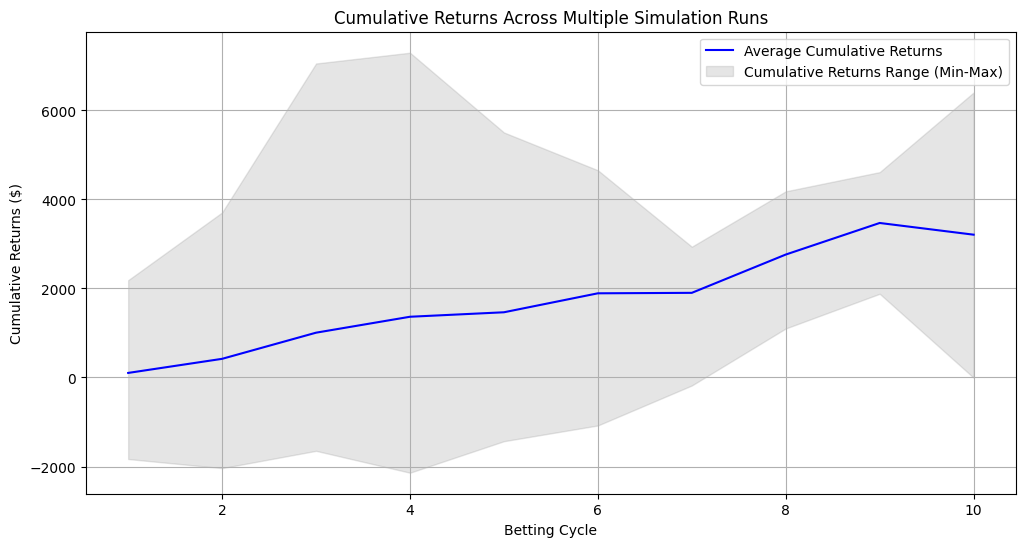

In [15]:
# Prepare data
profits_matrix = np.array([result['profit_over_time'] for result in all_runs_results])
cumulative_profits_matrix = np.cumsum(profits_matrix, axis=1)

average_cumulative_profits = np.mean(cumulative_profits_matrix, axis=0)
min_cumulative_profits = np.min(cumulative_profits_matrix, axis=0)
max_cumulative_profits = np.max(cumulative_profits_matrix, axis=0)

# Plotting
plt.figure(figsize=(12, 6))
cycles = range(1, betting_cycles + 1)

plt.plot(cycles, average_cumulative_profits, label='Average Cumulative Returns', color='blue')
plt.fill_between(cycles, min_cumulative_profits, max_cumulative_profits, color='gray', alpha=0.2, label='Cumulative Returns Range (Min-Max)')

plt.title('Cumulative Returns Across Multiple Simulation Runs')
plt.xlabel('Betting Cycle')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)
plt.show()

4.3 Summary Statistics

In [16]:
ending_liquidity_values = [result['ending_liquidity'] for result in all_runs_results]
total_profits = [sum(result['profit_over_time']) for result in all_runs_results]

print("Summary of Ending Liquidity Across Runs:")
print(f"Average Ending Liquidity: ${np.mean(ending_liquidity_values):.2f}")
print(f"Minimum Ending Liquidity: ${np.min(ending_liquidity_values):.2f}")
print(f"Maximum Ending Liquidity: ${np.max(ending_liquidity_values):.2f}\n")

print("Summary of Total Profit Across Runs:")
print(f"Average Total Profit: ${np.mean(total_profits):.2f}")
print(f"Minimum Total Profit: ${np.min(total_profits):.2f}")
print(f"Maximum Total Profit: ${np.max(total_profits):.2f}")


Summary of Ending Liquidity Across Runs:
Average Ending Liquidity: $9093.25
Minimum Ending Liquidity: $5392.76
Maximum Ending Liquidity: $12481.67

Summary of Total Profit Across Runs:
Average Total Profit: $3208.34
Minimum Total Profit: $-5.74
Maximum Total Profit: $6403.56


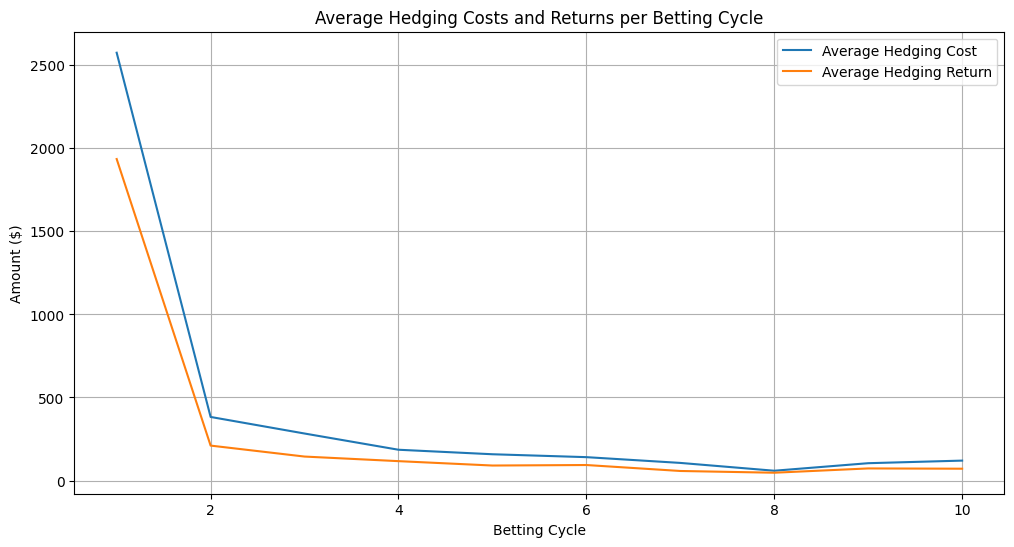

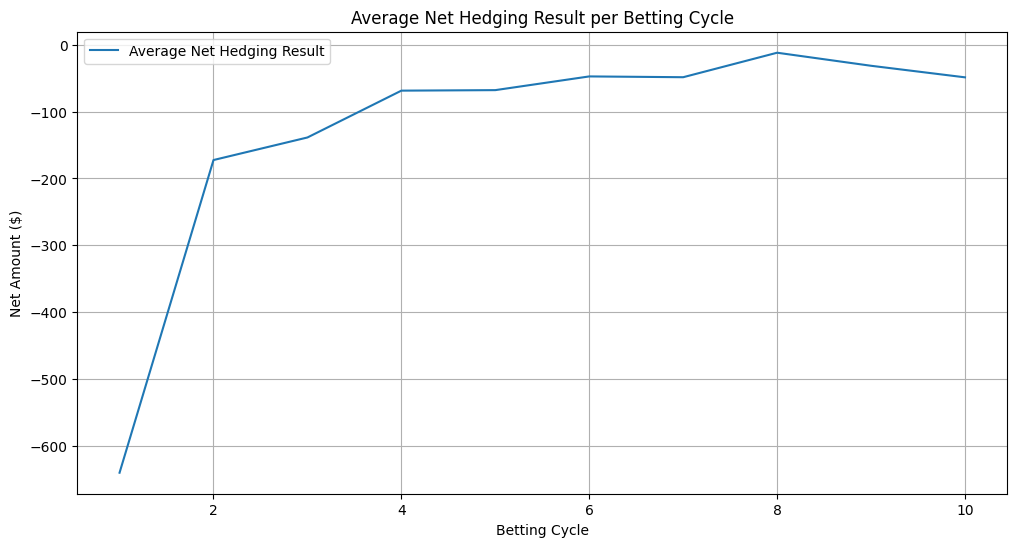

In [17]:
# Prepare data
hedging_costs_matrix = np.array([result['total_hedging_costs'] for result in all_runs_results])
hedging_returns_matrix = np.array([result['total_hedging_returns'] for result in all_runs_results])
hedging_net_matrix = np.array([result['total_hedging_net'] for result in all_runs_results])

average_hedging_costs = np.mean(hedging_costs_matrix, axis=0)
average_hedging_returns = np.mean(hedging_returns_matrix, axis=0)
average_hedging_net = np.mean(hedging_net_matrix, axis=0)

# Plotting Hedging Costs and Returns
plt.figure(figsize=(12, 6))
cycles = range(1, betting_cycles + 1)
plt.plot(cycles, average_hedging_costs, label='Average Hedging Cost')
plt.plot(cycles, average_hedging_returns, label='Average Hedging Return')
plt.title('Average Hedging Costs and Returns per Betting Cycle')
plt.xlabel('Betting Cycle')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Net Hedging Results
plt.figure(figsize=(12, 6))
plt.plot(cycles, average_hedging_net, label='Average Net Hedging Result')
plt.title('Average Net Hedging Result per Betting Cycle')
plt.xlabel('Betting Cycle')
plt.ylabel('Net Amount ($)')
plt.legend()
plt.grid(True)
plt.show()
